<a href="https://www.kaggle.com/code/sajjadhajian/seb-loan-risk-analysis?scriptVersionId=161733030" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

- The script employs XGBoost for loan default prediction using a real-world dataset, achieving an F1 score of 0.99. 

- Data preprocessing includes removing nulls, duplicates, and irrelevant columns, as well as optimizing datatypes, extracting numerical values from mixed number/text cells, consolidating infrequent categories, and one-hot encoding.

- Model optimization includes threshold optimization for the F1 score. 

- Model evaluation includes using a confusion matrix and finding feature importance.

Best Threshold: 0.21, Best F1 Score: 1.0
Confusion Matrix:
[[105109      0]
 [     0   1391]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105109
           1       1.00      1.00      1.00      1391

    accuracy                           1.00    106500
   macro avg       1.00      1.00      1.00    106500
weighted avg       1.00      1.00      1.00    106500



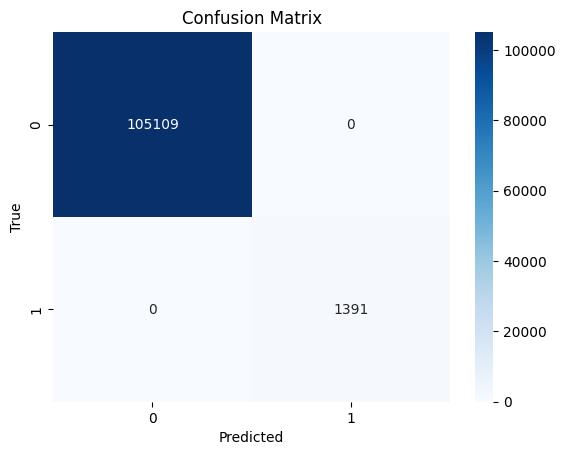

feature importance:
 [7.4927392e-04 0.0000000e+00 0.0000000e+00 6.1967250e-05 6.5481232e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.7908891e-04 1.6351036e-05 2.0215900e-04 0.0000000e+00 0.0000000e+00
 1.2290644e-03 0.0000000e+00 9.8218501e-01 1.9890393e-05 9.0291882e-03
 3.6090170e-04 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.0861699e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.0544208e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 2.9122244e-05 0.0000000e+00 0.0000000e+00 2.0928564e-05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 9.6571003e-04 0.0000000e+00 0.0000000e+00 3.3573564e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from xgboost import XGBClassifier

# Read the data
file_path = '/kaggle/input/loan-risk-analysis-dataset-real-world-data/Case_Data.csv'  # Update with your file path
df = pd.read_csv(file_path)

# Drop null columns
df = df.dropna(axis=1, how='all')

# Drop ID columns
df = df.drop(['Row ID', 'id', 'member_id'], axis=1)

# Drop duplicates
df = df.drop_duplicates()

# Drop rows with null labels
df = df.dropna(subset='loan_status').reset_index(drop=True)

# Optimize datatypes
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')

for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        scaled = (df[col] - df[col].min()) / (df[col].max() - df[col].min()) * 255
        # Convert scaled values to uint8, leaving NaN as is
        df[col] = scaled.apply(lambda x: np.nan if pd.isna(x) else np.uint8(x))      

# Rearranging the data
label_data = df['loan_status']
df = df.drop('loan_status', axis=1)
df['loan_status'] = label_data
label_data=[]

# Extract Months and Years
for col in df.drop('sub_grade', axis=1).columns:
    if df[col].dtype == 'category':
        extracted_numbers = []
        all_matched = True
        for row in df[col]:
            cell = str(row)
            if pd.notna(cell):
                # Regex pattern to match a number followed by 'month' or 'year' (with optional space)
                pattern = r'(?:<)?(\d+)(\+)?\s?(month[s]?|year[s]?)?'
                match = re.search(pattern, cell)
                if match:
                    # Extract the number part and convert to float
                    extracted_numbers.append(float(match.group(1)))
                else:
                    # If any cell in the column doesn't match, mark for non-conversion
                    all_matched = False
                    break  # Exit the loop early if any non-matching cell is found
        
        if all_matched:
            # Convert the entire column if all cells matched the pattern
            df[col] = pd.Series(extracted_numbers, index=df.index).astype('uint8')

# Replace infrequent categories with 'Other'
for col in df.select_dtypes(include=['category']).columns:
    # Calculate value counts and identify infrequent categories
    infrequent = df[col].value_counts() < 0.1*len(df[col]) 
    # Create a mask for rows that should be replaced with 'Other'
    mask = df[col].isin(infrequent[infrequent].index) 
    # Replace infrequent categories with 'Other'
    df[col] = pd.Categorical(np.where(mask, 'Other', df[col]),
                             categories=np.append(df[col].cat.categories[~infrequent], 'Other'))

# One-hot encode categorical columns and change dtype
categorical_columns = df.select_dtypes(include='category').columns
df_categorical = df[categorical_columns]
df_numerical = df.select_dtypes(exclude='category')
df_dummies = pd.get_dummies(df_categorical, columns=categorical_columns, drop_first=True, dtype=int, sparse=True)
df = pd.concat([df_numerical, df_dummies], axis=1)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]

# Shuffling the data
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df.to_csv('optimized_df.csv', index=False)

# Modeling the data

# Split data into train and test sets
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Initialize and fit XGBoost Classifier
model = XGBClassifier(random_state=1)
model.fit(X_train, y_train)

# Find the best threshold for the F1 score
y_scores = model.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0, 1, 101)
best_f1, best_thresh = 0, 0
for thresh in thresholds:
    y_pred_thresh = (y_scores > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1, best_thresh = f1, thresh
print(f"Best Threshold: {best_thresh}, Best F1 Score: {best_f1}")

threshold=best_thresh
y_pred=(y_scores > best_thresh).astype(int)

# Evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")
classification_rep = classification_report(y_test, y_pred)
print(f"Classification Report:\n{classification_rep}")

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
   
# Feature Importance
feature_importance = model.feature_importances_
print("feature importance:\n", feature_importance)